# Import Dependencies

In [1]:
import numpy as np
import pandas as pd

import json
import sys
import time
import datetime
import random
import collections
from pathlib import Path

import torch
import transformers
import datasets
from datasets import load_dataset

2023-12-13 22:09:17.026025: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("torch version: ", torch.__version__)
print("transformer version: ", transformers.__version__)
print("dataset version: ", datasets.__version__)

torch version:  1.12.1
transformer version:  4.24.0
dataset version:  2.10.1


# Reproducibility

In [3]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [4]:
fix_random(seed=42)

# Runtime Settings

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using Device: ", device)

Using Device:  cpu


# Load SQuAD v2 Dataset

In [6]:
data = load_dataset("squad_v2")

Found cached dataset squad_v2 (/Users/Home/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/09187c73c1b837c95d9a249cd97c2c3f1cebada06efe667b4427714b27639b1d)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
data

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 130319
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 11873
    })
})

In [13]:
def get_text(answer: list) -> str:
    """Extract only the text from the answers.text column 

    Args:
        answer: the answer.
    """
    if answer:
        return answer[0]
    else:
        return ""


train_dataframe = pd.json_normalize(data['train'])
train_dataframe["answers.text"] = train_dataframe["answers.text"].apply(get_text)

val_dataframe = pd.json_normalize(data['validation'])
val_dataframe["answers.text"] = val_dataframe["answers.text"].apply(get_text)

In [14]:
train_dataframe.head()

,id,title,context,question,answers.text,answers.answer_start
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,in the late 1990s,[269]
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,singing and dancing,[207]
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,2003,[526]
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"Houston, Texas",[166]
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,late 1990s,[276]


In [15]:
val_dataframe.head()

,id,title,context,question,answers.text,answers.answer_start
0,56ddde6b9a695914005b9628,Normans,The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,France,"[159, 159, 159, 159]"
1,56ddde6b9a695914005b9629,Normans,The Normans (Norman: Nourmands; French: Norman...,When were the Normans in Normandy?,10th and 11th centuries,"[94, 87, 94, 94]"
2,56ddde6b9a695914005b962a,Normans,The Normans (Norman: Nourmands; French: Norman...,From which countries did the Norse originate?,"Denmark, Iceland and Norway","[256, 256, 256, 256]"
3,56ddde6b9a695914005b962b,Normans,The Normans (Norman: Nourmands; French: Norman...,Who was the Norse leader?,Rollo,"[308, 308, 308, 308]"
4,56ddde6b9a695914005b962c,Normans,The Normans (Norman: Nourmands; French: Norman...,What century did the Normans first gain their ...,10th century,"[671, 649, 671, 671]"


In [21]:
train_dataframe['question'].apply(len).describe()

count    130319.000000
mean         58.507739
std          73.757111
min           1.000000
25%          44.000000
50%          55.000000
75%          69.000000
max       25651.000000
Name: question, dtype: float64

In [69]:
train_dataframe['context'].apply(len).describe()

count    130135.000000
mean        754.566673
std         307.624914
min         151.000000
25%         561.000000
50%         692.000000
75%         891.000000
max        3706.000000
Name: context, dtype: float64

In [72]:
train_dataframe['answers.text'].apply(len).describe()

count    130135.000000
mean         13.412472
std          20.007467
min           0.000000
25%           0.000000
50%           7.000000
75%          17.000000
max         239.000000
Name: answers.text, dtype: float64

- remove row which have question length more than 100

In [25]:
train_dataframe = train_dataframe[train_dataframe['question'].apply(len) <= 150]

# Analysis

<AxesSubplot:title={'center':'Context length histogram'}, ylabel='Frequency'>

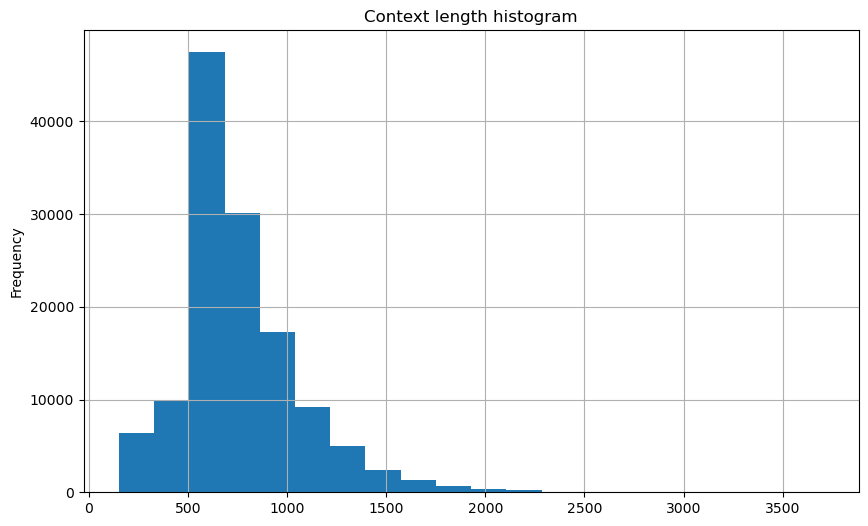

In [16]:
figsize = (10,6)
train_dataframe['context'].apply(len).plot.hist(title="Context length histogram", 
                                                bins=20, 
                                                figsize=figsize, 
                                                grid=True)

<AxesSubplot:title={'center':'Question length histogram'}, ylabel='Frequency'>

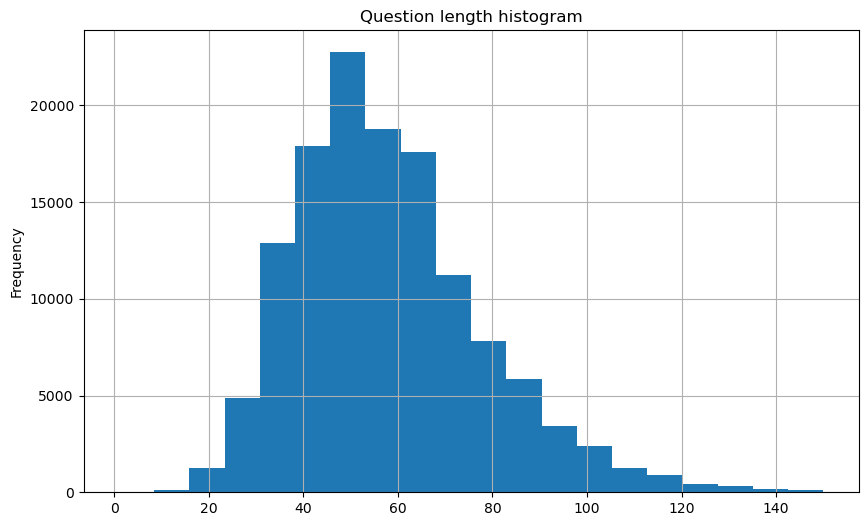

In [27]:
train_dataframe['question'].apply(len).plot.hist(title="Question length histogram", 
                                                 bins=20, 
                                                 figsize=figsize, 
                                                 grid=True)

<AxesSubplot:title={'center':'Answer length histogram'}, ylabel='Frequency'>

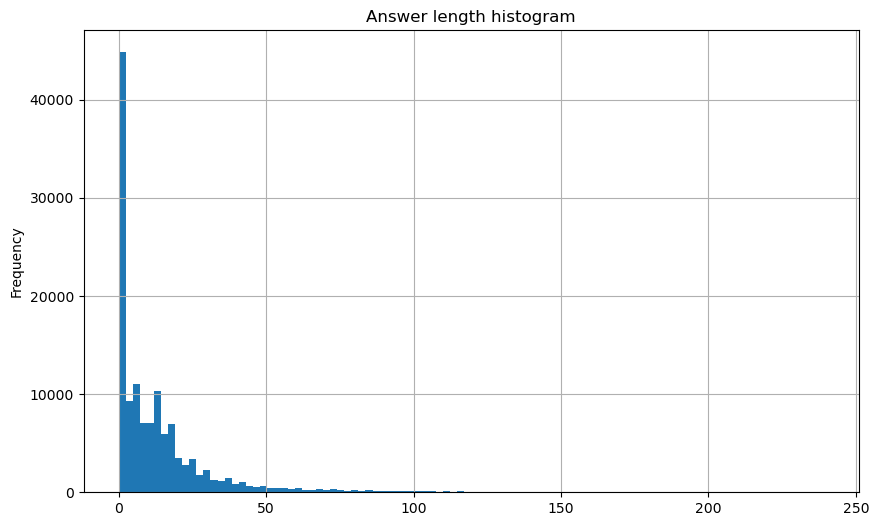

In [29]:
train_dataframe['answers.text'].apply(len).plot.hist(title="Answer length histogram", 
                                                     bins=100, 
                                                     figsize=figsize, 
                                                     grid=True)

In [30]:
#@title Show Samples { run: "auto", display-mode: "form" }

sample_index =  62194 #@param {type:"slider", min:0, max:120000, step:1}

def print_squad_sample(df: pd.core.frame.DataFrame, line_length: int=20, separator_length: int=120) -> None:
    sample = df.iloc[sample_index]
    title = sample.title.replace('_', ' ')
    print('TITLE: ')
    print(title)
    print('='*separator_length)
    context = sample.context.split()
    print('CONTEXT: ')
    lines = [' '.join(context[idx:idx+line_length]) for idx in range(0, len(context), line_length)]
    for l in lines:
        print(l)
    print('='*separator_length)
    questions = df[df.context.values==sample.context]
    max_len = len(max(questions.question, key=len)) + 5
    print("{: <{max_len}} {: <{max_len}}".format('QUESTION:','ANSWER:', max_len=max_len))
    for idx, row in questions.iterrows():
        question = row.question
        answer = row['answers.text']
        print("{: <{max_len}} {: <{max_len}}".format(question,answer, max_len=max_len))

print_squad_sample(train_dataframe)

TITLE: 
Cotton
CONTEXT: 
The era of manufactured fibers began with the development of rayon in France in the 1890s. Rayon is derived from
a natural cellulose and cannot be considered synthetic, but requires extensive processing in a manufacturing process, and led the less
expensive replacement of more naturally derived materials. A succession of new synthetic fibers were introduced by the chemicals industry in
the following decades. Acetate in fiber form was developed in 1924. Nylon, the first fiber synthesized entirely from petrochemicals, was
introduced as a sewing thread by DuPont in 1936, followed by DuPont's acrylic in 1944. Some garments were created from
fabrics based on these fibers, such as women's hosiery from nylon, but it was not until the introduction of polyester
into the fiber marketplace in the early 1950s that the market for cotton came under threat. The rapid uptake of
polyester garments in the 1960s caused economic hardship in cotton-exporting economies, especially i

- we can see that some question doesn't have a answers.

# Preprocessing the training data

In [84]:
from transformers import AutoTokenizer

model_checkpoint = "deepset/tinyroberta-squad2"
batch_size = 16

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [85]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [86]:
# tokenizer padding side
pad_on_right = tokenizer.padding_side == "right"

In [87]:
tokenizer("What is your's pet name?", "My pet's name is Sylvain.")

{'input_ids': [0, 2264, 16, 110, 18, 4716, 766, 116, 2, 2, 2387, 4716, 18, 766, 16, 28856, 1851, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [88]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [89]:
for i, example in enumerate(data['train']):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > 384:
        break
example = data['train'][i]

In [90]:
len(tokenizer(example["question"], example["context"])["input_ids"])

442

In [91]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [92]:
for x in tokenized_example["input_ids"]:
    print(tokenizer.decode(x), "\n")

<s>Beyonce got married in 2008 to whom?</s></s>On April 4, 2008, Beyoncé married Jay Z. She publicly revealed their marriage in a video montage at the listening party for her third studio album, I Am... Sasha Fierce, in Manhattan's Sony Club on October 22, 2008. I Am... Sasha Fierce was released on November 18, 2008 in the United States. The album formally introduces Beyoncé's alter ego Sasha Fierce, conceived during the making of her 2003 single "Crazy in Love", selling 482,000 copies in its first week, debuting atop the Billboard 200, and giving Beyoncé her third consecutive number-one album in the US. The album featured the number-one song "Single Ladies (Put a Ring on It)" and the top-five songs "If I Were a Boy" and "Halo". Achieving the accomplishment of becoming her longest-running Hot 100 single in her career, "Halo"'s success in the US helped Beyoncé attain more top-ten singles on the list than any other woman during the 2000s. It also included the successful "Sweet Dreams", a

In [93]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (3, 7), (8, 11), (12, 19), (20, 22), (23, 27), (28, 30), (31, 35), (35, 36), (0, 0), (0, 0), (0, 2), (3, 8), (9, 10), (10, 11), (12, 16), (16, 17), (18, 23), (23, 25), (26, 33), (34, 37), (38, 39), (39, 40), (41, 44), (45, 53), (54, 62), (63, 68), (69, 77), (78, 80), (81, 82), (83, 88), (89, 93), (93, 96), (97, 99), (100, 103), (104, 113), (114, 119), (120, 123), (124, 127), (128, 133), (134, 140), (141, 146), (146, 147), (148, 149), (150, 152), (152, 155), (156, 161), (162, 163), (163, 168), (168, 169), (170, 172), (173, 182), (182, 184), (185, 189), (190, 194), (195, 197), (198, 205), (206, 208), (208, 209), (210, 214), (214, 215), (216, 217), (218, 220), (220, 223), (224, 229), (230, 231), (231, 236), (237, 240), (241, 249), (250, 252), (253, 261), (262, 264), (264, 265), (266, 270), (271, 273), (274, 277), (278, 284), (285, 291), (291, 292), (293, 296), (297, 302), (303, 311), (312, 322), (323, 328), (328, 330), (330, 332), (333, 338), (339, 342), (343, 348), (349,

In [94]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

Bey Bey


In [95]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [96]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

21 22


In [97]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

 Jay Z
Jay Z


Now let's put everything together in one function we will apply to our training set.

In [98]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [99]:
features = prepare_train_features(data['train'][:1])

In [107]:
tokenized_datasets = data.map(prepare_train_features, 
                              batched=True, 
                              remove_columns=data["train"].column_names,
                              load_from_cache_file=False) 


Map:   0%|          | 0/130319 [00:00<?, ? examples/s]

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

# Fine Tune Model

In [108]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

In [109]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-squadv2",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

In [110]:
from transformers import default_data_collator

data_collator = default_data_collator

In [111]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
trainer.train()

In [ ]:
trainer.save_model("my-tinyroberta-squad2")

# Evaluation

In [112]:
for batch in trainer.get_eval_dataloader():
    break
    
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}

with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [113]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([16, 384]), torch.Size([16, 384]))

In [114]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 53,  39,  77,  85, 164,   0,   0,   0,   0, 209, 124,  43,   0,   0,
           0, 123]),
 tensor([ 53,  44,  81,  86, 165,   0,   0,   0,   0, 212, 125,  43,   0,   0,
           0, 124]))

In [115]:
n_best_size = 20

In [116]:
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

In [117]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [118]:
validation_features = data["validation"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=data["validation"].column_names
)

Map:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [119]:
raw_predictions = trainer.predict(validation_features)

The following columns in the test set don't have a corresponding argument in `RobertaForQuestionAnswering.forward` and have been ignored: example_id, offset_mapping. If example_id, offset_mapping are not expected by `RobertaForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 12165
  Batch size = 16


KeyboardInterrupt: 

In [ ]:
validation_features.set_format(type=validation_features.format["type"], 
                               columns=list(validation_features.features.keys()))


In [ ]:
max_answer_length = 30

In [ ]:
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = validation_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = datasets["validation"][0]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

In [ ]:
datasets["validation"][0]["answers"]

In [ ]:
import collections

examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [ ]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        if not squad_v2:
            predictions[example["id"]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example["id"]] = answer

    return predictions

In [ ]:
final_predictions = postprocess_qa_predictions(datasets["validation"], 
                                               validation_features, 
                                               raw_predictions.predictions)


In [ ]:
metric = load_metric("squad_v2")

In [ ]:
formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in final_predictions.items()]

references = [{"id": ex["id"], "answers": ex["answers"]} for ex in datasets["validation"]]
metric.compute(predictions=formatted_predictions, references=references)

In [ ]:
# trainer.push_to_hub()